In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
file_path = "XAUUSD_H1_202201022300_202410252300.csv"
df = pd.read_csv(file_path,delimiter="\t")
df.head()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
0,2022.01.02,23:00:00,1828.85,1831.75,1827.96,1828.45,1772,0,7
1,2022.01.03,00:00:00,1828.45,1831.00,1826.97,1830.23,2911,0,7
2,2022.01.03,01:00:00,1830.22,1831.50,1827.57,1828.82,3208,0,7
3,2022.01.03,02:00:00,1828.82,1828.88,1825.66,1826.16,2465,0,7
4,2022.01.03,03:00:00,1826.18,1826.84,1824.18,1825.70,2086,0,8


In [4]:
data = df['<CLOSE>'].values.astype(float)
scaler = MinMaxScaler(feature_range=(-1,1))
data_normalized = scaler.fit_transform(data.reshape(-1,1))

In [5]:
def create_sequences(data, input_seq_length, output_seq_length):
    xs = []
    ys = []
    for i in range(len(data) - input_seq_length - output_seq_length + 1):
        x = data[i:i + input_seq_length]
        y = data[i + input_seq_length:i + input_seq_length + output_seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


In [6]:
input_seq_length = 30
output_seq_length = 10
X, y = create_sequences(data_normalized, input_seq_length, output_seq_length)


In [7]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# Define a Simple RNN model

In [31]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=10):  # تغییر در output_size
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        last_time_step_output = rnn_out[:, -1, :]
        out = self.fc(last_time_step_output)
        return out

In [32]:
model = SimpleRNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
for batch_X, batch_y in train_loader:
    print("Batch X shape:", batch_X.shape)  # انتظار میرود: (batch_size, input_seq_length, 1)
    print("Batch y shape:", batch_y.shape)  # انتظار میرود: (batch_size, output_seq_length)
    break


Batch X shape: torch.Size([64, 30, 1])
Batch y shape: torch.Size([64, 10, 1])


In [34]:
num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).squeeze(-1)  # حذف بعد آخر
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device).squeeze(-1)  # حذف بعد آخر
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            epoch_test_loss += loss.item()
    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}')


Epoch [10/50], Train Loss: 0.000372, Test Loss: 0.003483
Epoch [20/50], Train Loss: 0.000500, Test Loss: 0.003457
Epoch [30/50], Train Loss: 0.000443, Test Loss: 0.002892
Epoch [40/50], Train Loss: 0.000409, Test Loss: 0.002776
Epoch [50/50], Train Loss: 0.000389, Test Loss: 0.002990


# Train the model

In [17]:
# print(batch_y.shape)  # ابعاد تنسور a
# print(outputs.shape)  # ابعاد تنسور b


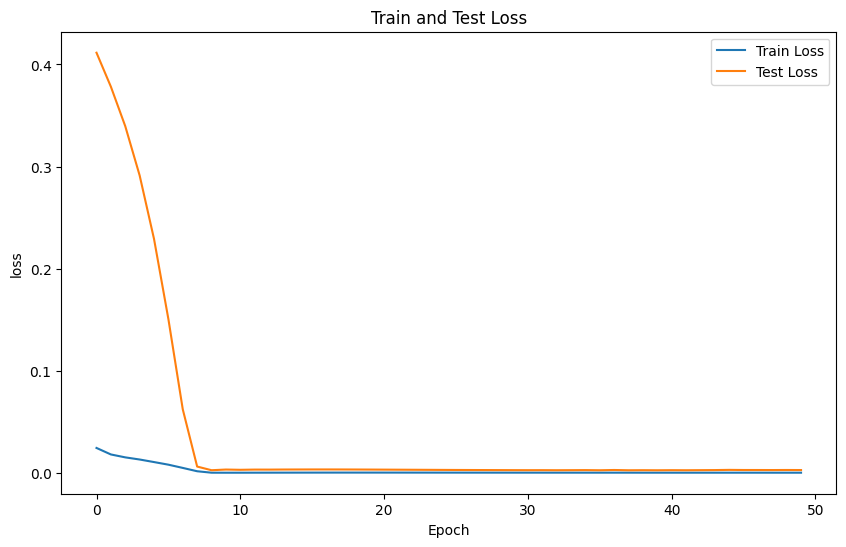

In [35]:
plt.figure(figsize=(10,6))
plt.plot(train_losses,label='Train Loss')
plt.plot(test_losses,label='Test Loss')
plt.title("Train and Test Loss")
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [36]:
model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

model.eval()

# Make predictions on the train set
with torch.no_grad():
    train_predictions = model(X_train_tensor).squeeze()  # Get predictions for train set
    train_predictions = train_predictions.cpu().numpy()  # Convert to NumPy for plotting

# Make predictions on the test set
with torch.no_grad():
    test_predictions = model(X_test_tensor).squeeze()  # Get predictions for test set
    test_predictions = test_predictions.cpu().numpy()  # Convert to NumPy for plotting

# Inverse transform the predictions and actual values to original scale
train_predicted_prices = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predicted_prices = scaler.inverse_transform(test_predictions.reshape(-1, 1))

train_actual_prices = scaler.inverse_transform(y_train_tensor.cpu().numpy().reshape(-1, 1))
test_actual_prices = scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

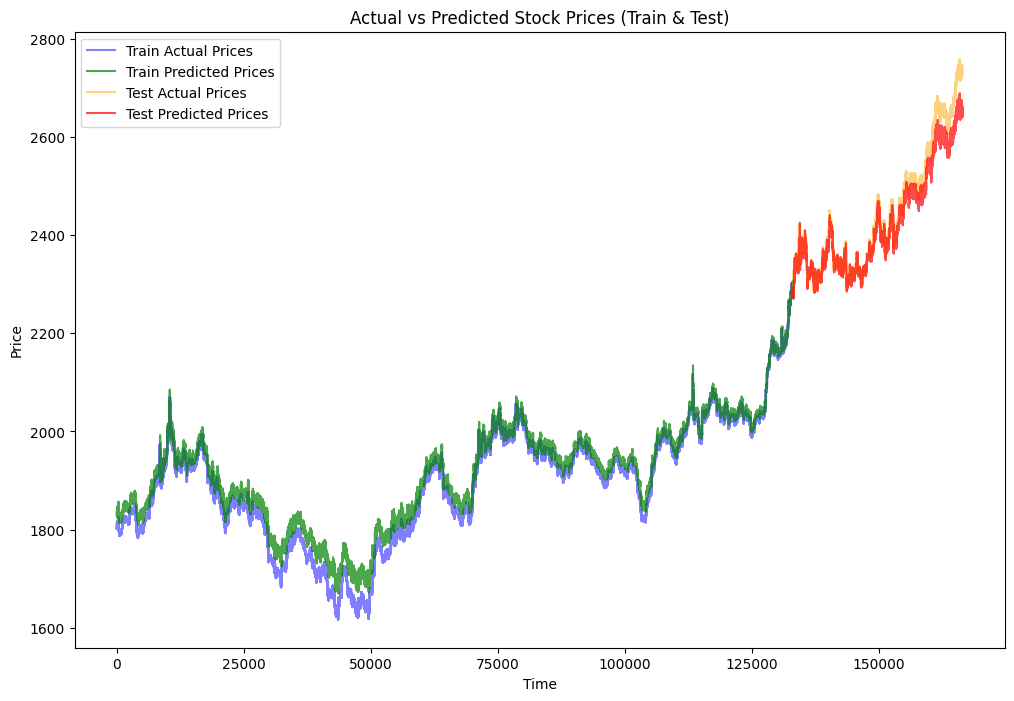

In [37]:
# Plot the actual prices vs predicted prices for both train and test sets
plt.figure(figsize=(12, 8))

# Plot train actual and predicted values
plt.plot(train_actual_prices, label='Train Actual Prices', color='blue', alpha=0.5)
plt.plot(train_predicted_prices, label='Train Predicted Prices', color='green', alpha=0.7)

# Plot test actual and predicted values
plt.plot(range(len(train_actual_prices), len(train_actual_prices) + len(test_actual_prices)),
         test_actual_prices, label='Test Actual Prices', color='orange', alpha=0.5)
plt.plot(range(len(train_actual_prices), len(train_actual_prices) + len(test_actual_prices)),
         test_predicted_prices, label='Test Predicted Prices', color='red', alpha=0.7)

plt.title('Actual vs Predicted Stock Prices (Train & Test)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


R² Score for Training Data: 0.9544
R² Score for Test Data: 0.9452


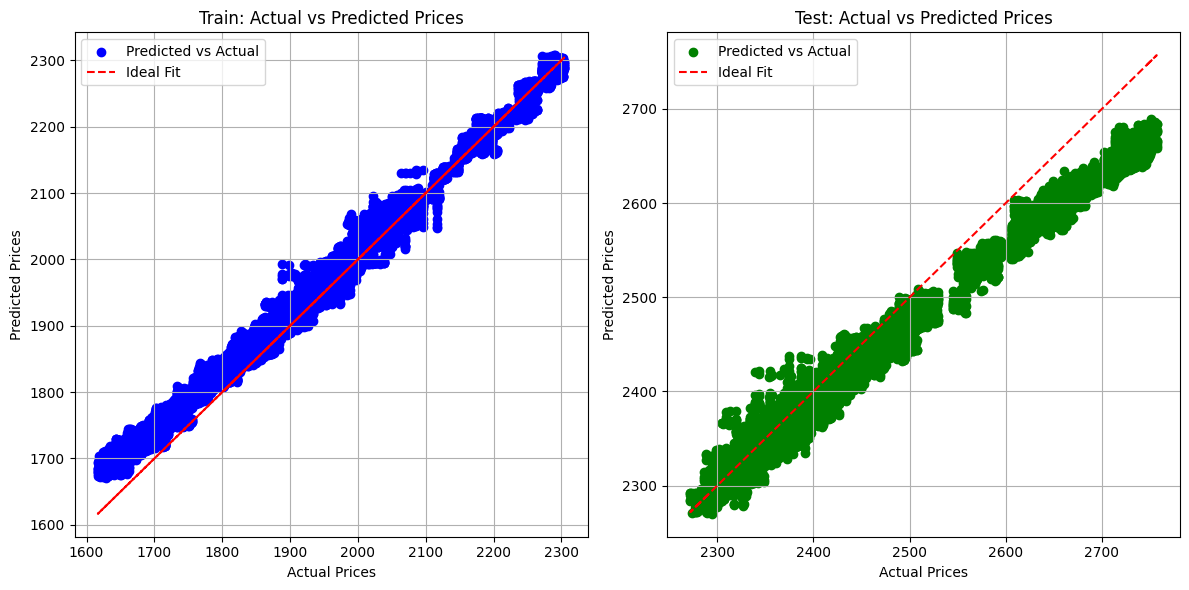

In [38]:
# تابع R²
def r2_score(y_true, y_pred):
    ss_total = torch.sum((y_true - torch.mean(y_true)) ** 2)  # واریانس کل
    ss_residual = torch.sum((y_true - y_pred) ** 2)  # واریانس باقی‌مانده
    return 1 - (ss_residual / ss_total)  # محاسبه R²

# انتقال مدل و داده‌ها به دستگاه (CPU/GPU)
model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

model.eval()

# پیش‌بینی برای داده‌های آموزشی
with torch.no_grad():
    train_predictions = model(X_train_tensor).squeeze()  # Get predictions for train set
    train_predictions = train_predictions.cpu().numpy()  # Convert to NumPy for plotting

# پیش‌بینی برای داده‌های آزمایشی
with torch.no_grad():
    test_predictions = model(X_test_tensor).squeeze()  # Get predictions for test set
    test_predictions = test_predictions.cpu().numpy()  # Convert to NumPy for plotting

# بازگشت به مقیاس اصلی
train_predicted_prices = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predicted_prices = scaler.inverse_transform(test_predictions.reshape(-1, 1))

# تبدیل مقادیر واقعی به مقیاس اصلی
train_actual_prices = scaler.inverse_transform(y_train_tensor.cpu().numpy().reshape(-1, 1))
test_actual_prices = scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

# تبدیل به تنسور PyTorch
y_train_true_tensor = torch.tensor(train_actual_prices, dtype=torch.float32).view(-1)
y_train_pred_tensor = torch.tensor(train_predicted_prices, dtype=torch.float32).view(-1)

# محاسبه R² برای داده‌های آموزشی
r2_train = r2_score(y_train_true_tensor, y_train_pred_tensor)
print(f'R² Score for Training Data: {r2_train:.4f}')

# تبدیل مقادیر واقعی تست به تنسور PyTorch
y_test_true_tensor = torch.tensor(test_actual_prices, dtype=torch.float32).view(-1)
y_test_pred_tensor = torch.tensor(test_predicted_prices, dtype=torch.float32).view(-1)

# محاسبه R² برای داده‌های تست
r2_test = r2_score(y_test_true_tensor, y_test_pred_tensor)
print(f'R² Score for Test Data: {r2_test:.4f}')

# رسم نمودار برای نمایش مقادیر واقعی و پیش‌بینی شده برای داده‌های آموزشی
plt.figure(figsize=(12, 6))

# نمودار برای داده‌های آموزشی
plt.subplot(1, 2, 1)
plt.scatter(y_train_true_tensor.numpy(), y_train_pred_tensor.numpy(), color='blue', label='Predicted vs Actual')
plt.plot(y_train_true_tensor.numpy(), y_train_true_tensor.numpy(), color='red', label='Ideal Fit', linestyle='--')  # خط ایده‌آل
plt.title('Train: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid()

# نمودار برای داده‌های آزمایشی
plt.subplot(1, 2, 2)
plt.scatter(y_test_true_tensor.numpy(), y_test_pred_tensor.numpy(), color='green', label='Predicted vs Actual')
plt.plot(y_test_true_tensor.numpy(), y_test_true_tensor.numpy(), color='red', label='Ideal Fit', linestyle='--')  # خط ایده‌آل
plt.title('Test: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Define a Simple LSTM model

In [39]:
# LSTM Model Definition
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=10):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step_output = lstm_out[:, -1, :]   
        out = self.fc(last_time_step_output)  # Use the last hidden state for prediction
        return out

In [40]:
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).squeeze(-1)  # حذف بعد آخر
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device).squeeze(-1)  # حذف بعد آخر
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            epoch_test_loss += loss.item()
    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}')


Epoch [10/50], Train Loss: 0.004313, Test Loss: 0.026252
Epoch [20/50], Train Loss: 0.001461, Test Loss: 0.011440
Epoch [30/50], Train Loss: 0.000844, Test Loss: 0.002751
Epoch [40/50], Train Loss: 0.000512, Test Loss: 0.002663
Epoch [50/50], Train Loss: 0.000386, Test Loss: 0.002867


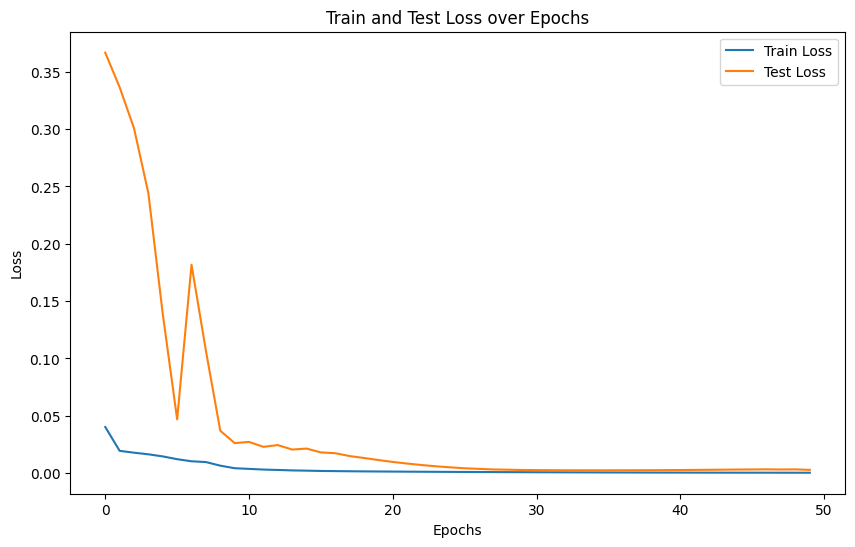

In [42]:
# Plot the Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

model.eval()

# Make predictions on the train set
with torch.no_grad():
    train_predictions = model(X_train_tensor).squeeze()  # Get predictions for train set
    train_predictions = train_predictions.cpu().numpy()  # Convert to NumPy for plotting

# Make predictions on the test set
with torch.no_grad():
    test_predictions = model(X_test_tensor).squeeze()  # Get predictions for test set
    test_predictions = test_predictions.cpu().numpy()  # Convert to NumPy for plotting

# Inverse transform the predictions and actual values to original scale
train_predicted_prices = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predicted_prices = scaler.inverse_transform(test_predictions.reshape(-1, 1))

train_actual_prices = scaler.inverse_transform(y_train_tensor.cpu().numpy().reshape(-1, 1))
test_actual_prices = scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

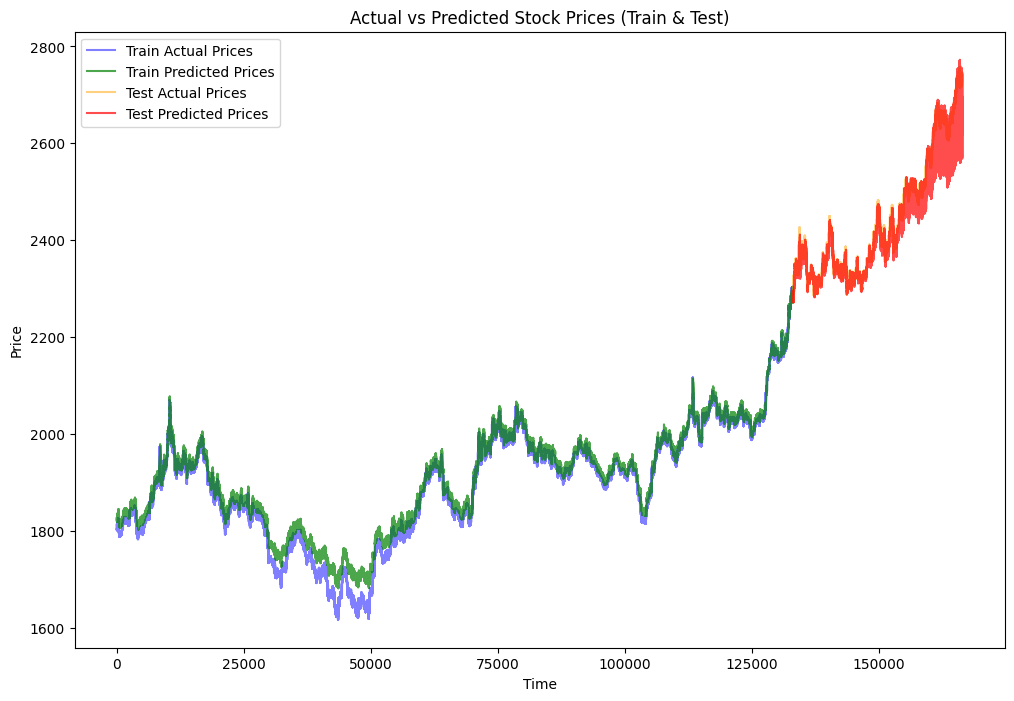

In [44]:
# Plotting the Actual vs Predicted Prices
plt.figure(figsize=(12, 8))
plt.plot(train_actual_prices, label='Train Actual Prices', color='blue', alpha=0.5)
plt.plot(train_predicted_prices, label='Train Predicted Prices', color='green', alpha=0.7)
plt.plot(range(len(train_actual_prices), len(train_actual_prices) + len(test_actual_prices)),
         test_actual_prices, label='Test Actual Prices', color='orange', alpha=0.5)
plt.plot(range(len(train_actual_prices), len(train_actual_prices) + len(test_actual_prices)),
         test_predicted_prices, label='Test Predicted Prices', color='red', alpha=0.7)

plt.title('Actual vs Predicted Stock Prices (Train & Test)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

R² Score for Training Data: 0.9686
R² Score for Test Data: 0.9469


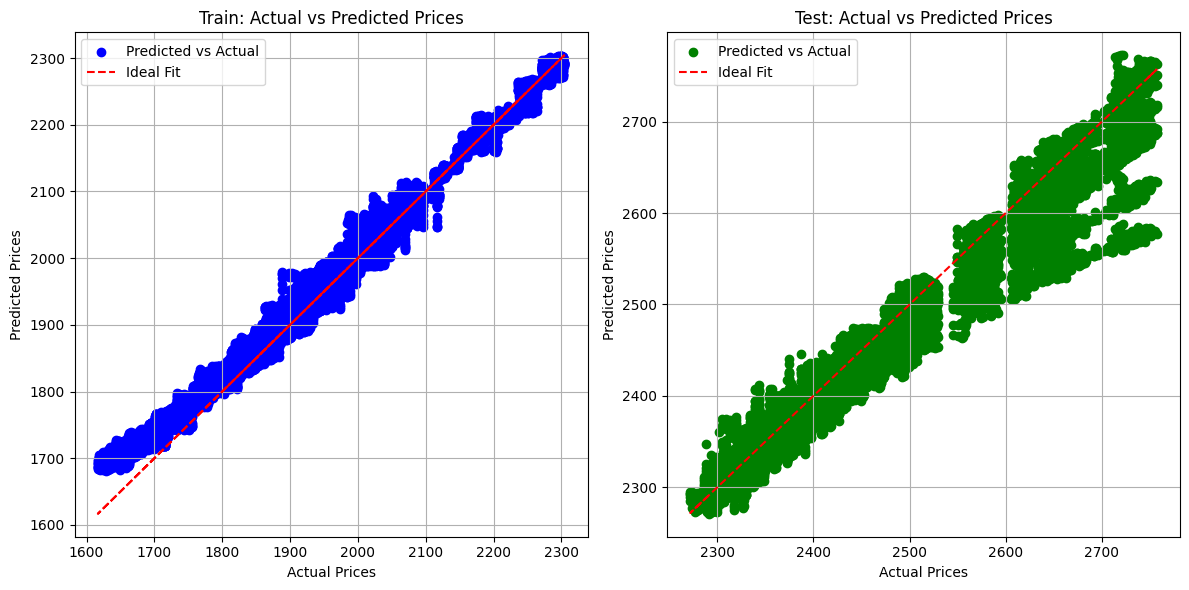

In [45]:
# تابع R²
def r2_score(y_true, y_pred):
    ss_total = torch.sum((y_true - torch.mean(y_true)) ** 2)  # واریانس کل
    ss_residual = torch.sum((y_true - y_pred) ** 2)  # واریانس باقی‌مانده
    return 1 - (ss_residual / ss_total)  # محاسبه R²

# انتقال مدل و داده‌ها به دستگاه (CPU/GPU)
model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

model.eval()

# پیش‌بینی برای داده‌های آموزشی
with torch.no_grad():
    train_predictions = model(X_train_tensor).squeeze()  # Get predictions for train set
    train_predictions = train_predictions.cpu().numpy()  # Convert to NumPy for plotting

# پیش‌بینی برای داده‌های آزمایشی
with torch.no_grad():
    test_predictions = model(X_test_tensor).squeeze()  # Get predictions for test set
    test_predictions = test_predictions.cpu().numpy()  # Convert to NumPy for plotting

# بازگشت به مقیاس اصلی
train_predicted_prices = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predicted_prices = scaler.inverse_transform(test_predictions.reshape(-1, 1))

# تبدیل مقادیر واقعی به مقیاس اصلی
train_actual_prices = scaler.inverse_transform(y_train_tensor.cpu().numpy().reshape(-1, 1))
test_actual_prices = scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

# تبدیل به تنسور PyTorch
y_train_true_tensor = torch.tensor(train_actual_prices, dtype=torch.float32).view(-1)
y_train_pred_tensor = torch.tensor(train_predicted_prices, dtype=torch.float32).view(-1)

# محاسبه R² برای داده‌های آموزشی
r2_train = r2_score(y_train_true_tensor, y_train_pred_tensor)
print(f'R² Score for Training Data: {r2_train:.4f}')

# تبدیل مقادیر واقعی تست به تنسور PyTorch
y_test_true_tensor = torch.tensor(test_actual_prices, dtype=torch.float32).view(-1)
y_test_pred_tensor = torch.tensor(test_predicted_prices, dtype=torch.float32).view(-1)

# محاسبه R² برای داده‌های تست
r2_test = r2_score(y_test_true_tensor, y_test_pred_tensor)
print(f'R² Score for Test Data: {r2_test:.4f}')

# رسم نمودار برای نمایش مقادیر واقعی و پیش‌بینی شده برای داده‌های آموزشی
plt.figure(figsize=(12, 6))

# نمودار برای داده‌های آموزشی
plt.subplot(1, 2, 1)
plt.scatter(y_train_true_tensor.numpy(), y_train_pred_tensor.numpy(), color='blue', label='Predicted vs Actual')
plt.plot(y_train_true_tensor.numpy(), y_train_true_tensor.numpy(), color='red', label='Ideal Fit', linestyle='--')  # خط ایده‌آل
plt.title('Train: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid()

# نمودار برای داده‌های آزمایشی
plt.subplot(1, 2, 2)
plt.scatter(y_test_true_tensor.numpy(), y_test_pred_tensor.numpy(), color='green', label='Predicted vs Actual')
plt.plot(y_test_true_tensor.numpy(), y_test_true_tensor.numpy(), color='red', label='Ideal Fit', linestyle='--')  # خط ایده‌آل
plt.title('Test: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Defining a GRU Model

In [46]:
# GRU Model Definition
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=10):
        super(GRUModel, self).__init__()
        self.GRU = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        GRU_out, _ = self.GRU(x)
        last_time_step_output = GRU_out[:, -1, :]   
        out = self.fc(last_time_step_output)  # Use the last hidden state for prediction
        return out

In [47]:
model = GRUModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).squeeze(-1)  # حذف بعد آخر
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device).squeeze(-1)  # حذف بعد آخر
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            epoch_test_loss += loss.item()
    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}')


Epoch [10/50], Train Loss: 0.000509, Test Loss: 0.001466
Epoch [20/50], Train Loss: 0.000468, Test Loss: 0.000711
Epoch [30/50], Train Loss: 0.000396, Test Loss: 0.001177
Epoch [40/50], Train Loss: 0.000346, Test Loss: 0.003065
Epoch [50/50], Train Loss: 0.000320, Test Loss: 0.006587


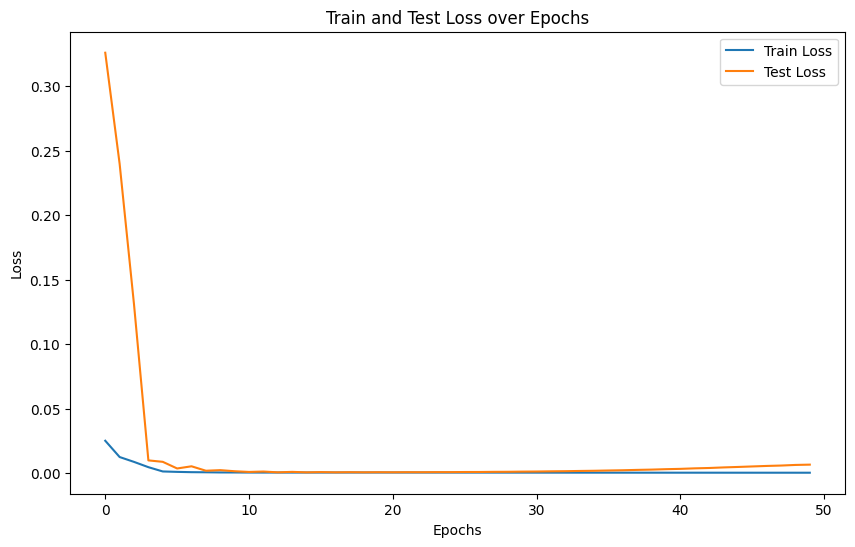

In [49]:
# Plot the Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

model.eval()

# Make predictions on the train set
with torch.no_grad():
    train_predictions = model(X_train_tensor).squeeze()  # Get predictions for train set
    train_predictions = train_predictions.cpu().numpy()  # Convert to NumPy for plotting

# Make predictions on the test set
with torch.no_grad():
    test_predictions = model(X_test_tensor).squeeze()  # Get predictions for test set
    test_predictions = test_predictions.cpu().numpy()  # Convert to NumPy for plotting

# Inverse transform the predictions and actual values to original scale
train_predicted_prices = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predicted_prices = scaler.inverse_transform(test_predictions.reshape(-1, 1))

train_actual_prices = scaler.inverse_transform(y_train_tensor.cpu().numpy().reshape(-1, 1))
test_actual_prices = scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

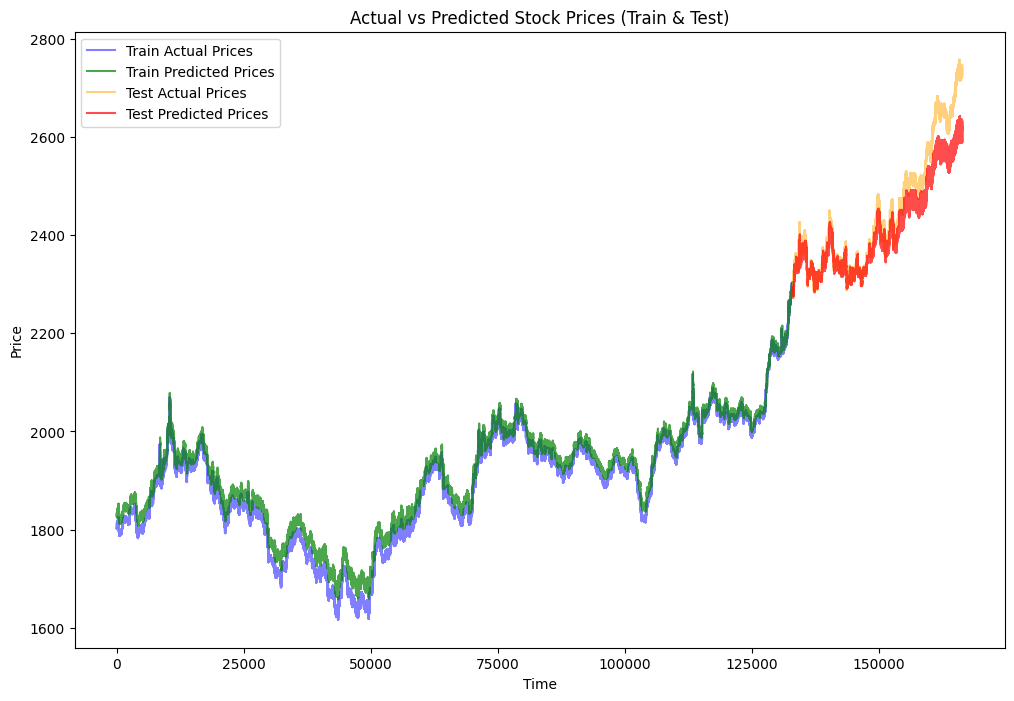

In [51]:
# Plotting the Actual vs Predicted Prices
plt.figure(figsize=(12, 8))
plt.plot(train_actual_prices, label='Train Actual Prices', color='blue', alpha=0.5)
plt.plot(train_predicted_prices, label='Train Predicted Prices', color='green', alpha=0.7)
plt.plot(range(len(train_actual_prices), len(train_actual_prices) + len(test_actual_prices)),
         test_actual_prices, label='Test Actual Prices', color='orange', alpha=0.5)
plt.plot(range(len(train_actual_prices), len(train_actual_prices) + len(test_actual_prices)),
         test_predicted_prices, label='Test Predicted Prices', color='red', alpha=0.7)

plt.title('Actual vs Predicted Stock Prices (Train & Test)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

R² Score for Training Data: 0.9617
R² Score for Test Data: 0.8784


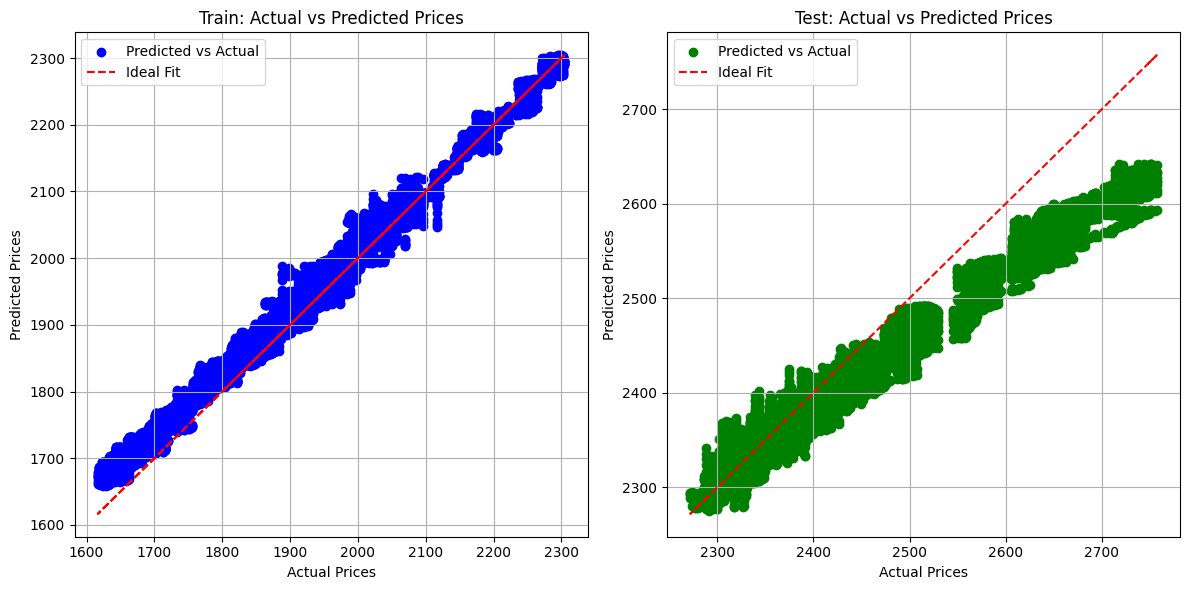

In [52]:
# تابع R²
def r2_score(y_true, y_pred):
    ss_total = torch.sum((y_true - torch.mean(y_true)) ** 2)  # واریانس کل
    ss_residual = torch.sum((y_true - y_pred) ** 2)  # واریانس باقی‌مانده
    return 1 - (ss_residual / ss_total)  # محاسبه R²

# انتقال مدل و داده‌ها به دستگاه (CPU/GPU)
model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

model.eval()

# پیش‌بینی برای داده‌های آموزشی
with torch.no_grad():
    train_predictions = model(X_train_tensor).squeeze()  # Get predictions for train set
    train_predictions = train_predictions.cpu().numpy()  # Convert to NumPy for plotting

# پیش‌بینی برای داده‌های آزمایشی
with torch.no_grad():
    test_predictions = model(X_test_tensor).squeeze()  # Get predictions for test set
    test_predictions = test_predictions.cpu().numpy()  # Convert to NumPy for plotting

# بازگشت به مقیاس اصلی
train_predicted_prices = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predicted_prices = scaler.inverse_transform(test_predictions.reshape(-1, 1))

# تبدیل مقادیر واقعی به مقیاس اصلی
train_actual_prices = scaler.inverse_transform(y_train_tensor.cpu().numpy().reshape(-1, 1))
test_actual_prices = scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

# تبدیل به تنسور PyTorch
y_train_true_tensor = torch.tensor(train_actual_prices, dtype=torch.float32).view(-1)
y_train_pred_tensor = torch.tensor(train_predicted_prices, dtype=torch.float32).view(-1)

# محاسبه R² برای داده‌های آموزشی
r2_train = r2_score(y_train_true_tensor, y_train_pred_tensor)
print(f'R² Score for Training Data: {r2_train:.4f}')

# تبدیل مقادیر واقعی تست به تنسور PyTorch
y_test_true_tensor = torch.tensor(test_actual_prices, dtype=torch.float32).view(-1)
y_test_pred_tensor = torch.tensor(test_predicted_prices, dtype=torch.float32).view(-1)

# محاسبه R² برای داده‌های تست
r2_test = r2_score(y_test_true_tensor, y_test_pred_tensor)
print(f'R² Score for Test Data: {r2_test:.4f}')

# رسم نمودار برای نمایش مقادیر واقعی و پیش‌بینی شده برای داده‌های آموزشی
plt.figure(figsize=(12, 6))

# نمودار برای داده‌های آموزشی
plt.subplot(1, 2, 1)
plt.scatter(y_train_true_tensor.numpy(), y_train_pred_tensor.numpy(), color='blue', label='Predicted vs Actual')
plt.plot(y_train_true_tensor.numpy(), y_train_true_tensor.numpy(), color='red', label='Ideal Fit', linestyle='--')  # خط ایده‌آل
plt.title('Train: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid()

# نمودار برای داده‌های آزمایشی
plt.subplot(1, 2, 2)
plt.scatter(y_test_true_tensor.numpy(), y_test_pred_tensor.numpy(), color='green', label='Predicted vs Actual')
plt.plot(y_test_true_tensor.numpy(), y_test_true_tensor.numpy(), color='red', label='Ideal Fit', linestyle='--')  # خط ایده‌آل
plt.title('Test: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Defining a BiGRU Model

In [53]:
# BiGRU Model Definition
class SimpleBiGRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=10):
        super(SimpleBiGRUModel, self).__init__()
        self.BiGRU = nn.GRU(input_size, hidden_size, batch_first=True,bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size)
        
    def forward(self, x):
        BiGRU_out, _ = self.BiGRU(x)
        last_time_step_output = BiGRU_out[:, -1, :] 
        out = self.fc(last_time_step_output)  # Use the last hidden state for prediction
        return out

In [54]:
model = SimpleBiGRUModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [56]:
num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).squeeze(-1)  # حذف بعد آخر
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device).squeeze(-1)  # حذف بعد آخر
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            epoch_test_loss += loss.item()
    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}')


Epoch [10/50], Train Loss: 0.000337, Test Loss: 0.000894
Epoch [20/50], Train Loss: 0.000402, Test Loss: 0.000862
Epoch [30/50], Train Loss: 0.000372, Test Loss: 0.000858
Epoch [40/50], Train Loss: 0.000347, Test Loss: 0.000925
Epoch [50/50], Train Loss: 0.000329, Test Loss: 0.001065


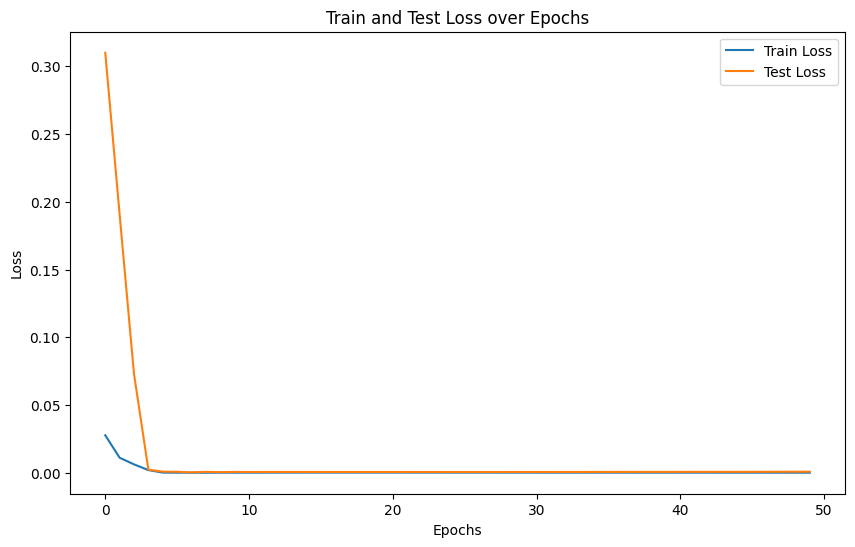

In [57]:
# Plot the Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [58]:
model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

model.eval()

# Make predictions on the train set
with torch.no_grad():
    train_predictions = model(X_train_tensor).squeeze()  # Get predictions for train set
    train_predictions = train_predictions.cpu().numpy()  # Convert to NumPy for plotting

# Make predictions on the test set
with torch.no_grad():
    test_predictions = model(X_test_tensor).squeeze()  # Get predictions for test set
    test_predictions = test_predictions.cpu().numpy()  # Convert to NumPy for plotting

# Inverse transform the predictions and actual values to original scale
train_predicted_prices = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predicted_prices = scaler.inverse_transform(test_predictions.reshape(-1, 1))

train_actual_prices = scaler.inverse_transform(y_train_tensor.cpu().numpy().reshape(-1, 1))
test_actual_prices = scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

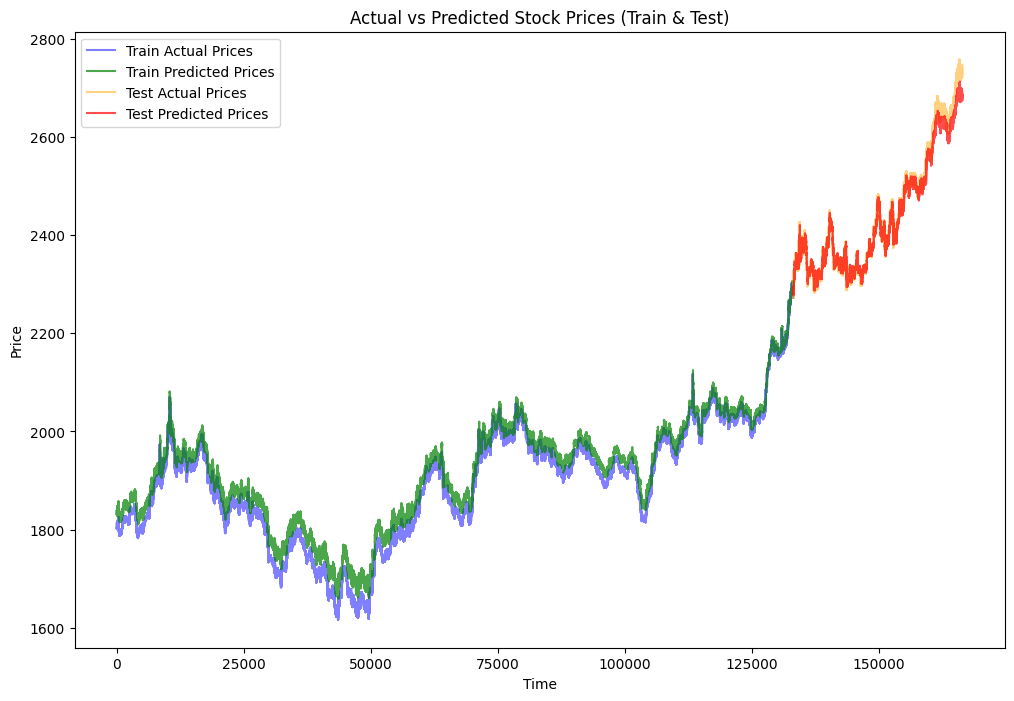

In [59]:
# Plotting the Actual vs Predicted Prices
plt.figure(figsize=(12, 8))
plt.plot(train_actual_prices, label='Train Actual Prices', color='blue', alpha=0.5)
plt.plot(train_predicted_prices, label='Train Predicted Prices', color='green', alpha=0.7)
plt.plot(range(len(train_actual_prices), len(train_actual_prices) + len(test_actual_prices)),
         test_actual_prices, label='Test Actual Prices', color='orange', alpha=0.5)
plt.plot(range(len(train_actual_prices), len(train_actual_prices) + len(test_actual_prices)),
         test_predicted_prices, label='Test Predicted Prices', color='red', alpha=0.7)

plt.title('Actual vs Predicted Stock Prices (Train & Test)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

R² Score for Training Data: 0.9493
R² Score for Test Data: 0.9811


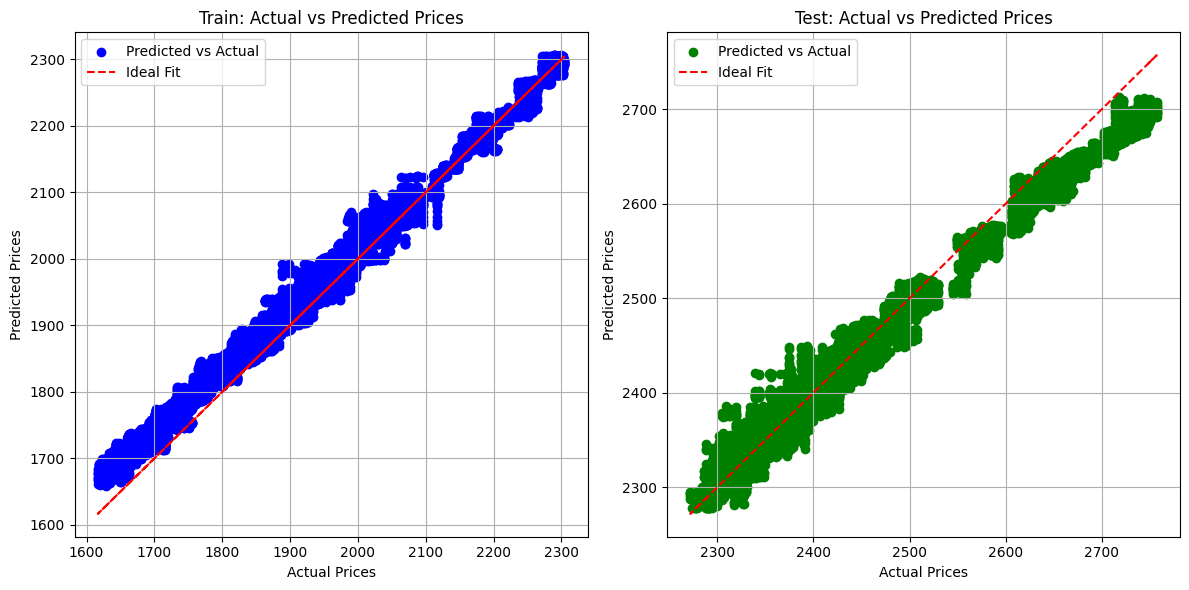

In [60]:

# تابع R²
def r2_score(y_true, y_pred):
    ss_total = torch.sum((y_true - torch.mean(y_true)) ** 2)  # واریانس کل
    ss_residual = torch.sum((y_true - y_pred) ** 2)  # واریانس باقی‌مانده
    return 1 - (ss_residual / ss_total)  # محاسبه R²

# انتقال مدل و داده‌ها به دستگاه (CPU/GPU)
model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

model.eval()

# پیش‌بینی برای داده‌های آموزشی
with torch.no_grad():
    train_predictions = model(X_train_tensor).squeeze()  # Get predictions for train set
    train_predictions = train_predictions.cpu().numpy()  # Convert to NumPy for plotting

# پیش‌بینی برای داده‌های آزمایشی
with torch.no_grad():
    test_predictions = model(X_test_tensor).squeeze()  # Get predictions for test set
    test_predictions = test_predictions.cpu().numpy()  # Convert to NumPy for plotting

# بازگشت به مقیاس اصلی
train_predicted_prices = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predicted_prices = scaler.inverse_transform(test_predictions.reshape(-1, 1))

# تبدیل مقادیر واقعی به مقیاس اصلی
train_actual_prices = scaler.inverse_transform(y_train_tensor.cpu().numpy().reshape(-1, 1))
test_actual_prices = scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

# تبدیل به تنسور PyTorch
y_train_true_tensor = torch.tensor(train_actual_prices, dtype=torch.float32).view(-1)
y_train_pred_tensor = torch.tensor(train_predicted_prices, dtype=torch.float32).view(-1)

# محاسبه R² برای داده‌های آموزشی
r2_train = r2_score(y_train_true_tensor, y_train_pred_tensor)
print(f'R² Score for Training Data: {r2_train:.4f}')

# تبدیل مقادیر واقعی تست به تنسور PyTorch
y_test_true_tensor = torch.tensor(test_actual_prices, dtype=torch.float32).view(-1)
y_test_pred_tensor = torch.tensor(test_predicted_prices, dtype=torch.float32).view(-1)

# محاسبه R² برای داده‌های تست
r2_test = r2_score(y_test_true_tensor, y_test_pred_tensor)
print(f'R² Score for Test Data: {r2_test:.4f}')

# رسم نمودار برای نمایش مقادیر واقعی و پیش‌بینی شده برای داده‌های آموزشی
plt.figure(figsize=(12, 6))

# نمودار برای داده‌های آموزشی
plt.subplot(1, 2, 1)
plt.scatter(y_train_true_tensor.numpy(), y_train_pred_tensor.numpy(), color='blue', label='Predicted vs Actual')
plt.plot(y_train_true_tensor.numpy(), y_train_true_tensor.numpy(), color='red', label='Ideal Fit', linestyle='--')  # خط ایده‌آل
plt.title('Train: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid()

# نمودار برای داده‌های آزمایشی
plt.subplot(1, 2, 2)
plt.scatter(y_test_true_tensor.numpy(), y_test_pred_tensor.numpy(), color='green', label='Predicted vs Actual')
plt.plot(y_test_true_tensor.numpy(), y_test_true_tensor.numpy(), color='red', label='Ideal Fit', linestyle='--')  # خط ایده‌آل
plt.title('Test: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
